### ライブラリのImport

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from dsets import getOneDiceRotate90
from dsets import getOneDiceImageInfoListFromArea
from dsets import getDevidedImageInfoList
from dsets import ImageDataset

from models import RegNetWrapper
from models import ResNet18Wrapper

/home/takafumi/MyAIComp/SonyDice/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-26 03:06:47.279482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 03:06:47.279551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 03:06:47.279654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 03:06:47.293689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### 画像の前処理

In [3]:
imgs, labels = getOneDiceRotate90(data_type='train')

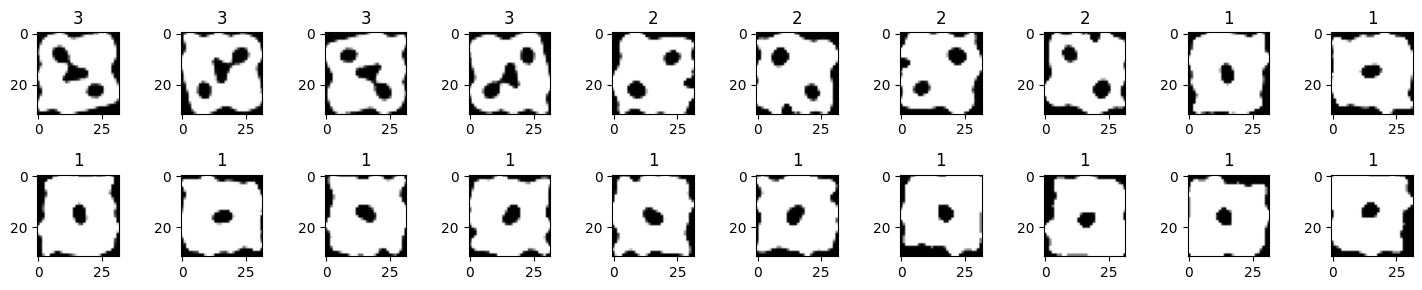

In [4]:
# 可視化
n = 20
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(labels[i])
    plt.tight_layout()

##### 訓練データ, 検証データの平均, 標準偏差の算出

In [5]:
from torchvision import transforms
from sklearn.model_selection import train_test_split

trn_imgs, val_imgs, trn_labels, val_labels = \
    train_test_split(imgs, labels, train_size=0.8, stratify=labels, random_state=1)

image_ToTensor = transforms.ToTensor()

# 訓練データの平均
import torch
trn_img_sum = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_sum += torch.sum(img_t[0])
# print(trn_img_sum)
trn_mean = trn_img_sum / (32*32*len(trn_imgs))
print(f'訓練データの平均: {trn_mean}')

# 訓練データの標準偏差
trn_img_s2 = 0
for trn_img in trn_imgs:
    img_t = image_ToTensor(trn_img)
    trn_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
trn_std = torch.sqrt(trn_img_s2/(32*32*len(trn_imgs)))
print(f'訓練データの標準偏差: {trn_std}')   

# 検証データ
import torch
val_img_sum = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_sum += torch.sum(img_t[0])
# print(val_img_sum)
val_mean = val_img_sum / (32*32*len(val_imgs))
print(f'検証データの平均: {val_mean}')

# 訓練データの標準偏差
val_img_s2 = 0
for val_img in val_imgs:
    img_t = image_ToTensor(val_img)
    val_img_s2 += torch.sum((img_t[0] - trn_mean)**2)
val_std = torch.sqrt(val_img_s2/(32*32*len(val_imgs)))
print(f'検証データの標準偏差: {val_std}')

訓練データの平均: 0.7347307801246643
訓練データの標準偏差: 0.42427778244018555
検証データの平均: 0.734638512134552
検証データの標準偏差: 0.4243113696575165


##### DataLoader作成

In [2]:
BATCH_SIZE = 128

In [3]:
train_ds = ImageDataset(data_type='trn')
valid_ds = ImageDataset(data_type='val')

In [4]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    drop_last=True
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

### 学習

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
model = ResNet18Wrapper()
model.to(device)

ResNet18Wrapper(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [7]:
writer = SummaryWriter(log_dir="./log/one_dice/resnet18/")

In [8]:
torch.cuda.empty_cache()

In [9]:
EPOCH_NUM = 20
VAL_CADENSE = 1

base_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
base_scheduler = CosineLRScheduler(
    base_optimizer,
    t_initial=100,
    lr_min=1e-7,
    warmup_t=3,
    warmup_lr_init=1e-6,
    warmup_prefix=True
)

criterion = nn.CrossEntropyLoss()

In [10]:
model

ResNet18Wrapper(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [11]:
best_acc = -1
pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # 1epochで学習したデータの数
    train_data_num = 0

    # 正解した総数
    acc_num = 0

    # lossの保存リスト
    loss_epoch = []

    # バッチごとに処理する
    for iter_num, (X, y) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)

        base_optimizer.zero_grad()

        with torch.autocast("cuda"):
            y_logit, y_softmax = model(X)
            loss = criterion(y_logit, y)

        loss.backward()
        base_optimizer.step()

        # lossを記録
        loss_batch = loss.to('cpu').detach().numpy().copy()
        loss_epoch.append(loss_batch)

        # softmaxによる確率で目を決定
        _, max_idx = torch.max(y_softmax, dim=1)
        max_idx_c = max_idx.to('cpu').detach().numpy().copy()
        y_c = y.to('cpu').detach().numpy().copy()

        # ラベルと合致する予測の数を数えてacc_numに加算する
        acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # 処理したデータの数を加算
        train_data_num += len(max_idx_c)
        
        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

    loss_mean = sum(loss_epoch)/len(loss_epoch)
    acc = acc_num / train_data_num

    writer.add_scalar("train/loss", loss.item(), epoch)
    writer.add_scalar("train/acc", acc, epoch)


    print(f'trn loss: {loss_mean:.4f}, trn acc: {acc:.4f}')
        
    base_scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_epoch = []

        # 検証データのacc
        acc_num = 0

        for iter_num, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                y_logit, y_softmax = model(X)
                loss = criterion(y_logit, y)

            # lossを記録
            loss_batch = loss.to('cpu').detach().numpy().copy()
            loss_epoch.append(loss_batch)

            # softmaxによる確率で目を決定
            _, max_idx = torch.max(y_softmax, dim=1)
            max_idx_c = max_idx.to('cpu').detach().numpy().copy()
            y_c = y.to('cpu').detach().numpy().copy()

            # ラベルと合致する予測の数を数えてacc_numに加算する
            acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # バッチ平均損失と全データに対するACC
        loss_mean = sum(loss_epoch)/len(loss_epoch)
        acc = acc_num / len(valid_ds)
    
        writer.add_scalar("valid/loss", loss.item(), epoch)  
        writer.add_scalar("valid/acc", acc, epoch)
        print(f'val loss: {loss_mean:.4f}, val acc: {acc:.4f}')

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f'/mnt/c/Users/user/MyData/SonyDice/models/resnet18_E{epoch}.pt')

writer.close()

Epoch/Iter 0/2496:   0%|          | 0/20 [01:34<?, ?it/s]

trn loss: 1.1455, trn acc: 0.5823


Epoch/Iter 1/0:   5%|▌         | 1/20 [01:50<34:54, 110.23s/it]   

val loss: 0.5123, val acc: 0.8539


Epoch/Iter 1/2496:   5%|▌         | 1/20 [03:22<34:54, 110.23s/it]

trn loss: 0.2640, trn acc: 0.9260


Epoch/Iter 2/1:  10%|█         | 2/20 [03:37<32:30, 108.36s/it]   

val loss: 0.1040, val acc: 0.9732


Epoch/Iter 2/2496:  10%|█         | 2/20 [05:10<32:30, 108.36s/it]

trn loss: 0.0099, trn acc: 0.9975


Epoch/Iter 3/0:  15%|█▌        | 3/20 [05:25<30:42, 108.40s/it]   

val loss: 0.0054, val acc: 0.9988


Epoch/Iter 3/2496:  15%|█▌        | 3/20 [06:58<30:42, 108.40s/it]

trn loss: 0.0067, trn acc: 0.9985


Epoch/Iter 4/1:  20%|██        | 4/20 [07:13<28:50, 108.16s/it]   

val loss: 0.0048, val acc: 0.9990


Epoch/Iter 4/2496:  20%|██        | 4/20 [08:44<28:50, 108.16s/it]

trn loss: 0.0070, trn acc: 0.9984


Epoch/Iter 5/4:  25%|██▌       | 5/20 [09:00<26:53, 107.54s/it]   

val loss: 0.0061, val acc: 0.9987


Epoch/Iter 5/2496:  25%|██▌       | 5/20 [10:32<26:53, 107.54s/it]

trn loss: 0.0055, trn acc: 0.9987


Epoch/Iter 6/0:  30%|███       | 6/20 [10:47<25:04, 107.48s/it]   

val loss: 0.0044, val acc: 0.9991


Epoch/Iter 6/2496:  30%|███       | 6/20 [12:22<25:04, 107.48s/it]

trn loss: 0.0042, trn acc: 0.9990


Epoch/Iter 7/4:  35%|███▌      | 7/20 [12:37<23:28, 108.32s/it]   

val loss: 0.0052, val acc: 0.9989


Epoch/Iter 7/2496:  35%|███▌      | 7/20 [14:09<23:28, 108.32s/it]

trn loss: 0.0038, trn acc: 0.9991


Epoch/Iter 8/0:  40%|████      | 8/20 [14:25<21:38, 108.19s/it]   

val loss: 0.0040, val acc: 0.9993


Epoch/Iter 8/2496:  40%|████      | 8/20 [16:08<21:38, 108.19s/it]

trn loss: 0.0032, trn acc: 0.9993


Epoch/Iter 9/3:  45%|████▌     | 9/20 [16:23<20:24, 111.29s/it]   

val loss: 0.0052, val acc: 0.9991


Epoch/Iter 9/2496:  45%|████▌     | 9/20 [18:05<20:24, 111.29s/it]

trn loss: 0.0029, trn acc: 0.9994


Epoch/Iter 10/3:  50%|█████     | 10/20 [18:21<18:52, 113.23s/it]  

val loss: 0.0046, val acc: 0.9991


Epoch/Iter 10/2496:  50%|█████     | 10/20 [19:53<18:52, 113.23s/it]

trn loss: 0.0029, trn acc: 0.9993


Epoch/Iter 11/4:  55%|█████▌    | 11/20 [20:09<16:44, 111.66s/it]   

val loss: 0.0038, val acc: 0.9992


Epoch/Iter 11/2496:  55%|█████▌    | 11/20 [21:41<16:44, 111.66s/it]

trn loss: 0.0029, trn acc: 0.9994


Epoch/Iter 12/3:  60%|██████    | 12/20 [21:57<14:44, 110.57s/it]   

val loss: 0.0040, val acc: 0.9992


Epoch/Iter 12/2496:  60%|██████    | 12/20 [23:30<14:44, 110.57s/it]

trn loss: 0.0029, trn acc: 0.9994


Epoch/Iter 13/4:  65%|██████▌   | 13/20 [23:45<12:49, 109.93s/it]   

val loss: 0.0045, val acc: 0.9991


Epoch/Iter 13/2496:  65%|██████▌   | 13/20 [25:17<12:49, 109.93s/it]

trn loss: 0.0025, trn acc: 0.9994


Epoch/Iter 14/4:  70%|███████   | 14/20 [25:33<10:54, 109.14s/it]   

val loss: 0.0038, val acc: 0.9992


Epoch/Iter 14/2496:  70%|███████   | 14/20 [27:05<10:54, 109.14s/it]

trn loss: 0.0023, trn acc: 0.9995


Epoch/Iter 15/1:  75%|███████▌  | 15/20 [27:20<09:03, 108.64s/it]   

val loss: 0.0036, val acc: 0.9994


Epoch/Iter 15/2496:  75%|███████▌  | 15/20 [28:52<09:03, 108.64s/it]

trn loss: 0.0023, trn acc: 0.9995


Epoch/Iter 16/3:  80%|████████  | 16/20 [29:07<07:12, 108.11s/it]   

val loss: 0.0049, val acc: 0.9993


Epoch/Iter 16/2496:  80%|████████  | 16/20 [30:39<07:12, 108.11s/it]

trn loss: 0.0023, trn acc: 0.9995


Epoch/Iter 17/3:  85%|████████▌ | 17/20 [30:54<05:23, 107.79s/it]   

val loss: 0.0040, val acc: 0.9992


Epoch/Iter 17/2496:  85%|████████▌ | 17/20 [32:26<05:23, 107.79s/it]

trn loss: 0.0020, trn acc: 0.9996


Epoch/Iter 18/3:  90%|█████████ | 18/20 [32:41<03:35, 107.66s/it]   

val loss: 0.0039, val acc: 0.9992


Epoch/Iter 18/2496:  90%|█████████ | 18/20 [34:25<03:35, 107.66s/it]

trn loss: 0.0022, trn acc: 0.9995


Epoch/Iter 19/3:  95%|█████████▌| 19/20 [34:40<01:51, 111.03s/it]   

val loss: 0.0040, val acc: 0.9990


Epoch/Iter 19/2496:  95%|█████████▌| 19/20 [36:24<01:51, 111.03s/it]

trn loss: 0.0020, trn acc: 0.9996


Epoch/Iter 19/2496: 100%|██████████| 20/20 [36:39<00:00, 109.97s/it]

val loss: 0.0040, val acc: 0.9994


##### FCだけファインチューン
resnet18だとあんまり意味ない

In [35]:
writer = SummaryWriter(log_dir="./log/one_dice_finetune/")

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
torch.cuda.empty_cache()

In [38]:
# モデルの読み込み
model = RegNetWrapper()
model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/regnet32_E4.pt'))
# FC層だけ学習可能に設定
model.to(device)
model.train()
model.requires_grad_(False)
model.regnet.fc.requires_grad_(True)

Linear(in_features=3712, out_features=6, bias=True)

In [39]:
model

RegNetWrapper(
  (regnet): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_size=

In [40]:
EPOCH_NUM = 20
VAL_CADENSE = 1

base_optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
base_scheduler = CosineLRScheduler(
    base_optimizer,
    t_initial=100,
    lr_min=1e-7,
    warmup_t=3,
    warmup_lr_init=1e-6,
    warmup_prefix=True
)

criterion = nn.CrossEntropyLoss()

In [41]:
best_acc = -1
pbar = tqdm(range(EPOCH_NUM))

for epoch in pbar:
    # モデルを学習モードにする
    model.train()

    # 1epochで学習したデータの数
    train_data_num = 0

    # 正解した総数
    acc_num = 0

    # lossの保存リスト
    loss_epoch = []

    # バッチごとに処理する
    for iter_num, (X, y) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)

        base_optimizer.zero_grad()

        with torch.autocast("cuda"):
            y_logit, y_softmax = model(X)
            loss = criterion(y_logit, y)

        loss.backward()
        base_optimizer.step()

        # lossを記録
        loss_batch = loss.to('cpu').detach().numpy().copy()
        loss_epoch.append(loss_batch)

        # softmaxによる確率で目を決定
        _, max_idx = torch.max(y_softmax, dim=1)
        max_idx_c = max_idx.to('cpu').detach().numpy().copy()
        y_c = y.to('cpu').detach().numpy().copy()

        # ラベルと合致する予測の数を数えてacc_numに加算する
        acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # 処理したデータの数を加算
        train_data_num += len(max_idx_c)
        
        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}")

    loss_mean = sum(loss_epoch)/len(loss_epoch)
    acc = acc_num / train_data_num

    writer.add_scalar("train/loss", loss.item(), epoch)
    writer.add_scalar("train/acc", acc, epoch)


    print(f'trn loss: {loss_mean:.4f}, trn acc: {acc:.4f}')
        
    base_scheduler.step(epoch)

    # validation
    if epoch == 0 or epoch % VAL_CADENSE == 0 or epoch == EPOCH_NUM-1:
        # 検証モードにする
        model.eval()

        # 検証データのloss
        loss_epoch = []

        # 検証データのacc
        acc_num = 0

        for iter_num, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad(), torch.autocast("cuda"):
                y_logit, y_softmax = model(X)
                loss = criterion(y_logit, y)

            # lossを記録
            loss_batch = loss.to('cpu').detach().numpy().copy()
            loss_epoch.append(loss_batch)

            # softmaxによる確率で目を決定
            _, max_idx = torch.max(y_softmax, dim=1)
            max_idx_c = max_idx.to('cpu').detach().numpy().copy()
            y_c = y.to('cpu').detach().numpy().copy()

            # ラベルと合致する予測の数を数えてacc_numに加算する
            acc_num += accuracy_score(max_idx_c, y_c, normalize=False)

        # バッチ平均損失と全データに対するACC
        loss_mean = sum(loss_epoch)/len(loss_epoch)
        acc = acc_num / len(valid_ds)
    
        writer.add_scalar("valid/loss", loss.item(), epoch)
        print(f'val loss: {loss_mean:.4f}, val acc: {acc:.4f}')

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f'/mnt/c/Users/user/MyData/SonyDice/models/regnet32_finetune_E{epoch}.pt')

writer.close()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch/Iter 0/2496:   0%|          | 0/20 [02:18<?, ?it/s]

trn loss: 0.0056, trn acc: 0.9986
val loss: 0.0060, val acc: 0.9986


Epoch/Iter 1/2496:   5%|▌         | 1/20 [05:08<56:09, 177.35s/it]

trn loss: 0.0056, trn acc: 0.9986
val loss: 0.0060, val acc: 0.9986


Epoch/Iter 2/2496:  10%|█         | 2/20 [08:00<51:54, 173.05s/it]

trn loss: 0.0055, trn acc: 0.9986
val loss: 0.0056, val acc: 0.9986


Epoch/Iter 3/2253:  15%|█▌        | 3/20 [10:42<1:00:39, 214.07s/it]


KeyboardInterrupt: 

### テストデータの予測

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##### 画像データの作成

In [3]:
# 一つのサイコロを持つ画像
test_idx_one_dice, imgs_test_one_dice, _ = getOneDiceImageInfoListFromArea(data_type='test')
print(f'一つのサイコロを持つ画像の枚数: {len(imgs_test_one_dice)}')

一つのサイコロを持つ画像の枚数: 5040


In [4]:
# 2つのサイコロを持つ画像を分離し、サイコロをそれぞれ切り取った画像のリスト
imgs_test_devided = getDevidedImageInfoList()
print(f'2つのサイコロを持つ画像を分離した枚数: {len(imgs_test_devided)}')

2つのサイコロを持つ画像を分離した枚数: 9920


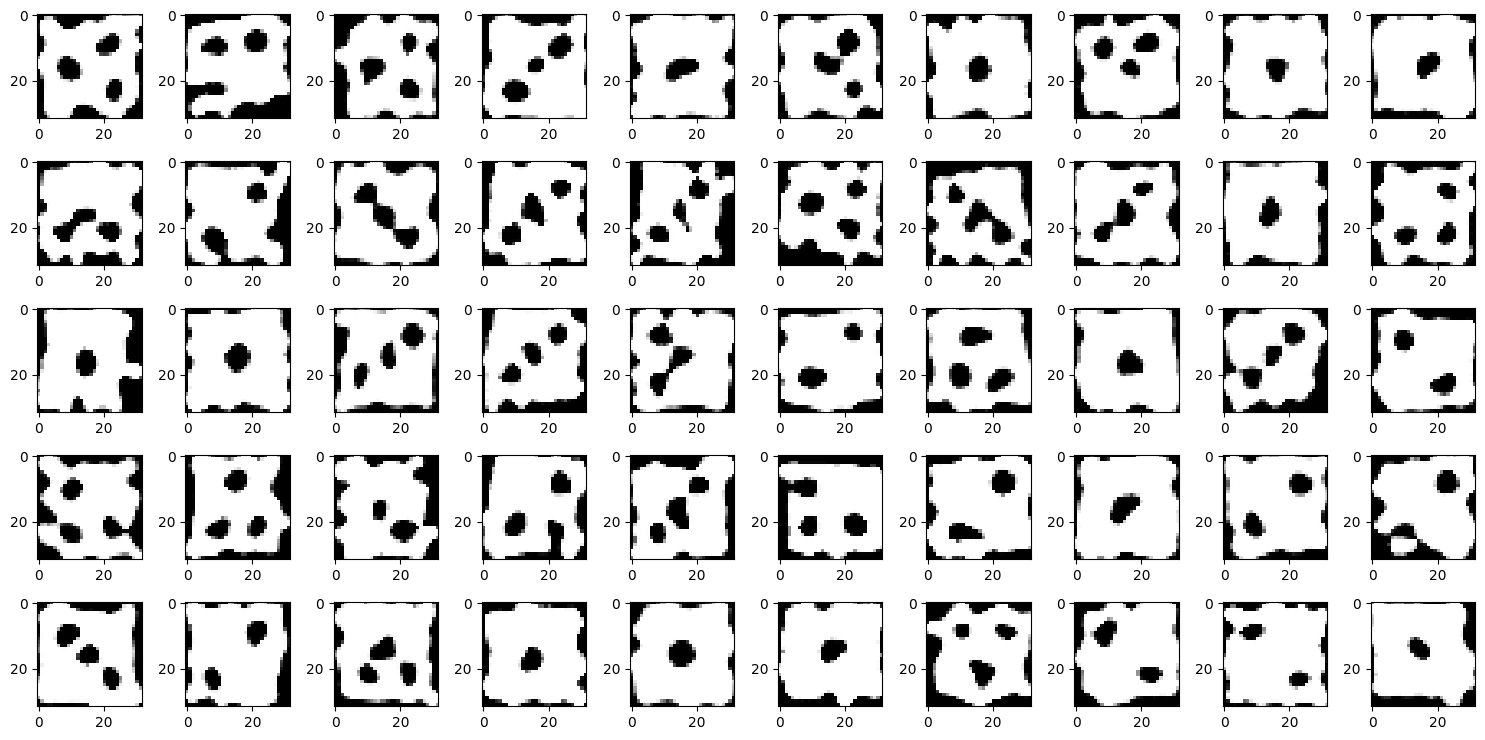

In [5]:
# 1つのサイコロを持つ画像の可視化
n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs_test_one_dice[i], cmap='gray')
    plt.tight_layout()

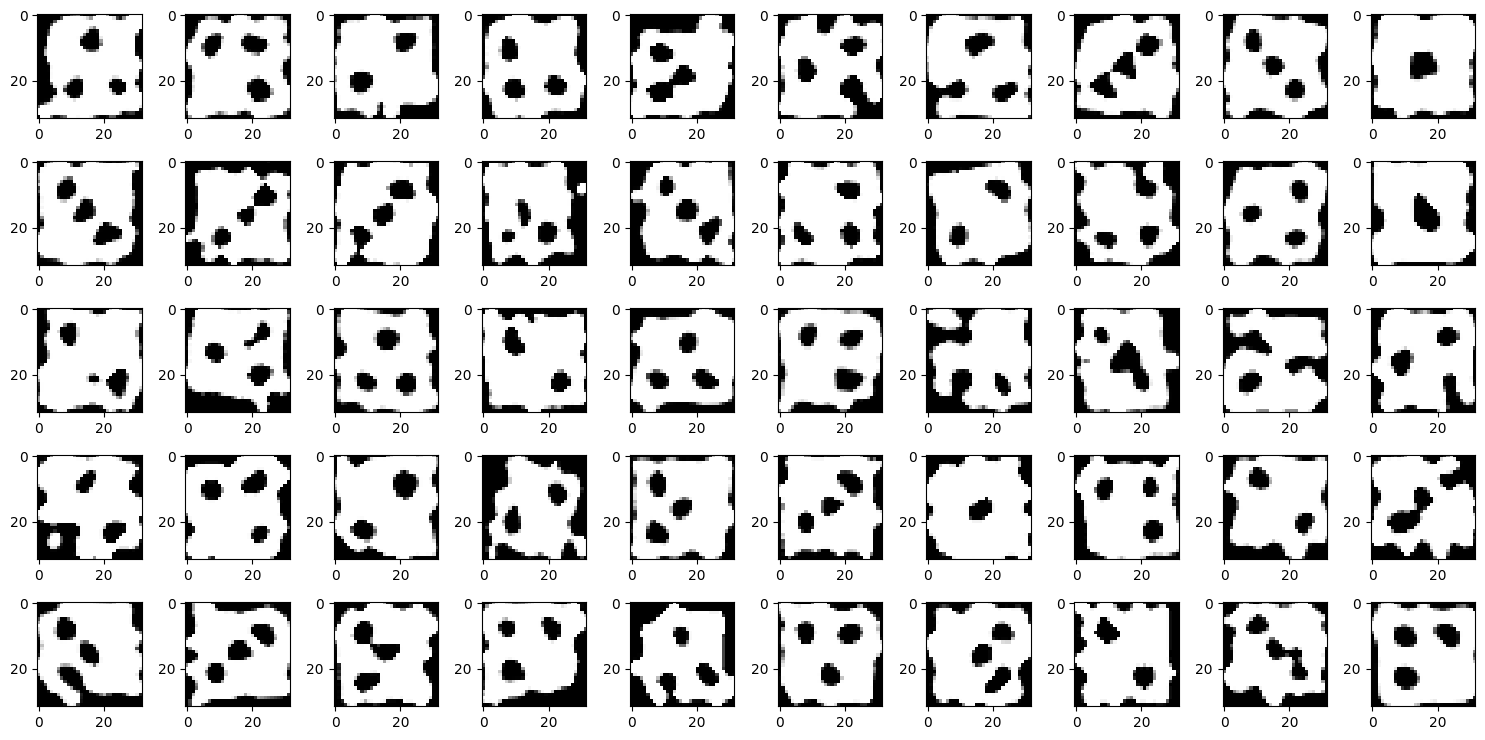

In [6]:
# 2つのサイコロを持つ画像の可視化
n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs_test_devided[i], cmap='gray')
    plt.tight_layout()

In [7]:
# 全画像リストの連結
imgs_test_all = imgs_test_one_dice + imgs_test_devided
len(imgs_test_all)

14960

##### テストデータの標準偏差の算出

In [8]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for one_dice_img_test in imgs_test_all:
    img_t = image_ToTensor(one_dice_img_test)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (32*32*len(imgs_test_all))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for one_dice_img_test in imgs_test_all:
    img_t = image_ToTensor(one_dice_img_test)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(32*32*len(imgs_test_all)))
print(f'テストデータの標準偏差: {test_img_std}')   

テストデータの平均: 0.7313995361328125
テストデータの標準偏差: 0.42626360058784485


In [9]:
def testTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.7314), (0.42626))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [10]:
# Testデータ用のDataset
class TestDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = testTransformer(img)
    
        return img_t

In [11]:
BATCH_SIZE = 128
test_ds = TestDataset(imgs=imgs_test_all)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

##### model の読み込み

In [12]:
model = ResNet18Wrapper()
model.load_state_dict(torch.load('/mnt/c/Users/user/MyData/SonyDice/models/resnet18_E14.pt'))
model.to(device)

ResNet18Wrapper(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [13]:
torch.cuda.empty_cache()

In [14]:
pred_label = torch.zeros(len(test_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(test_dl), total=len(test_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 1

100%|██████████| 117/117 [00:04<00:00, 23.55it/s]


In [15]:
pred_label = pred_label.numpy()
pred_label

array([6, 4, 6, ..., 2, 6, 6])

In [16]:
one_dice_rolls = pred_label[:len(imgs_test_one_dice)]
devided_dice_rolls = pred_label[len(imgs_test_one_dice):]

two_dice_rolls = []

for i, roll in enumerate(devided_dice_rolls):
    if i % 2 == 0:
        tmp = roll
    else:
        tmp += roll
        two_dice_rolls.append(tmp)

In [17]:
# 二つのサイコロを持つ画像のindex
test_idx_two_dice = []
cnt = 0
for i in range(10000):
    if i == test_idx_one_dice[cnt]:
        if i < test_idx_one_dice[-1]:
            cnt += 1
    else:
        test_idx_two_dice.append(i)

In [18]:
dice_rolls = []
submit_df = pd.read_csv('/mnt/c/Users/user/MyData/SonyDice/sample_submit.csv', header=None)

In [19]:
for i, idx in enumerate(test_idx_one_dice):
    submit_df.loc[idx, 1] = one_dice_rolls[i]

for i, idx in enumerate(test_idx_two_dice):
    submit_df.loc[idx, 1] = two_dice_rolls[i]

In [20]:
submit_df

,0,1
0,0,6
1,1,10
2,2,6
3,3,4
4,4,6
...,...,...
9995,9995,4
9996,9996,5
9997,9997,3
9998,9998,5


In [21]:
submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice_resnet18.csv', header=False, index=False)